# Titanic
This is my second attempt at the Titanic dataset. Some of the improvements were due to  ideas taken from [Ken Jee](https://www.kaggle.com/kenjee/titanic-project-example) and [Jason Chong](https://www.youtube.com/watch?v=GSk-EEu1zkA). My goals include becoming more familiar with seaborn and sklearn, which means that there are a number of unnecessary steps that were added for the sake of learning.

Code can also be found [here](https://github.com/RaulRPrado/Titanic-Kaggle).

***
### The notebook is structured as:

[1. Exploring the data](#data_exploration)

[2. Processing the data (cleaning and feature engeneering)](#data_processing)

[3. Building and evaluating models](#model_building)

[4. Selecting the best model](#model_selection)

[5. Applying best model to test data](#model_applying)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Loading training data for exploration
data_train = pd.read_csv('data/train.csv')

<a id='data_exploration'></a>
## 1. Exploring the data

In this section I will take a broad look at the data and collect ideas for the data processing, which will come later.

In [3]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Splitting columns into numerical and categorical
categorical_cols = list(data_train.select_dtypes(exclude=['number','bool_']).columns)
numerical_cols = [c for c in data_train.columns if c not in categorical_cols]
numerical_cols.remove('PassengerId')

print('Categorical Variables: {}'.format(categorical_cols))
print('Numerical Variables: {}'.format(numerical_cols))

Categorical Variables: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Numerical Variables: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


***
#### Notes
- There are 5 categorical and 5 numerical variables (+ the labels). These two groups of variables will be treated separetly in the next subsections.
- For numerical variables, I will plot the distribution and check for outliers, need for normalization, and possible correlations with the label.
- For categorical variables, I will check for possibility/necessity of encoding, correlations with labels and relevance.
***

### 1.1 Exploring numerical data

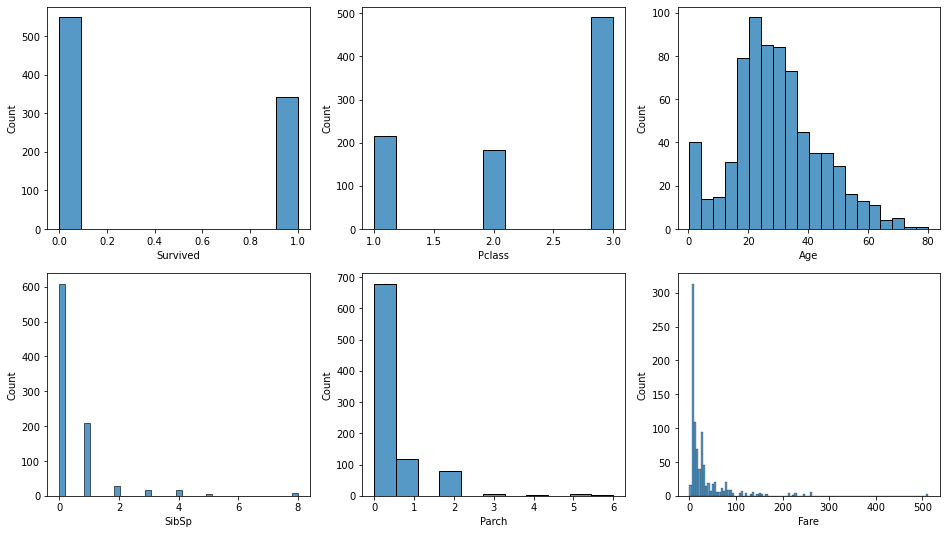

In [7]:
# Plotting the single variable distributions of all numerical data
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
axs = axs.flatten()

for col, ax in zip(numerical_cols, axs):
    sns.histplot(data_train, x=col, ax=ax)

***
#### Ideas
- *Pclass* is a code for the class of the passenger (1 - first class, 2 - second class ...). Therefore, the value of Pclass does not carry the actual ordinal information and the relationship between the classes. The one to treat this kind of variable is by **(one-hot) encoding** them into extra variables which indicates which class the passenger was into. In this case, I will encode Pclass into the variables **IsFirstClass** and **IsSecondClass**. The third class variable is not necessary because the same information can be obtained by the previous ones ( "IsThirdClass == 1" is equivalent to "IsFirstClass == 0 and IsSecondClass == 0").
- *Fare* is a very skewed distribution, therefore it may be beneficial to normalize it through a log function.
- *Age* is quite well behaved, gaussian-like distribution - nothing to do.
- *SibSp* and *Parch* are also well behaved, but discrete distributions. They are also skewed, therefore it could be beneficial to perform a log normalization on them. 
***

<AxesSubplot:>

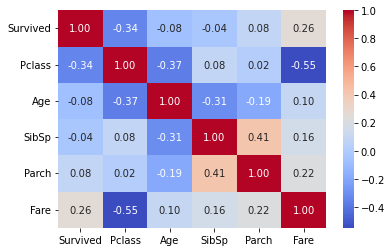

In [8]:
# Looking at the correlations
sns.heatmap(
    data_train[numerical_cols].corr(),
    annot = True,
    fmt = '.2f',
    cmap = 'coolwarm'
)

***
#### Notes
- Negative correlation between *Pclass* and *Fare* because higher class (smaller *Pclass*) tickets should be more expensive.
- Positive correlation between *Parch* and *SibSp* because both are related to the family size. Meaning that families travelling together will be higher on both variables.
***

### 1.2 Exploring categorical data

#### 1.2.1 Cabin

In [9]:
data_train['Cabin'].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

In [10]:
data_train['Cabin'].dropna().head(20)

1             C85
3            C123
6             E46
10             G6
11           C103
21            D56
23             A6
27    C23 C25 C27
31            B78
52            D33
54            B30
55            C52
61            B28
62            C83
66            F33
75          F G73
88    C23 C25 C27
92            E31
96             A5
97        D10 D12
Name: Cabin, dtype: object

***
#### Notes
- Large fraction of missing data.
- Follows the pattern "single letter + number".
- There may be multiple cabins for the same passenger.
***

***
#### Ideas
- The first letter (cabin group) could carry relevant information.
- The number of cabins could carry relevant information.
***

In [11]:
# Cabin group (first letter of the cabin)
def get_cabin_group(cabin):
    ''' Returns cabin group for a given cabin value'''
    if isinstance(cabin, str):
        cabin_split = cabin.split()
        return cabin_split[0][0]
    else:
        return 'none'

In [12]:
# Apllying get_cabin_group to Cabin data
data_train['CabinGroup'] = data_train['Cabin'].map(get_cabin_group)

Text(0.5, 1.0, 'Survival Probability by SibSp')

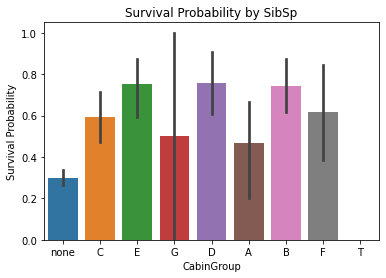

In [13]:
# Plotting  survival rates for each CabinGroup
sns.barplot(x='CabinGroup', y='Survived', data=data_train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by SibSp')

***
#### Conclusion
- *CabinGroup* **is not significantly correlated** with the surviving probability, the distributions is quite flat. The *CabinGroup* would need to be one-hot encoded later, which means 9 more variables. To avoid having to deal with too many variables I will not use *CabinGroup* for the classification. 
***

In [14]:
# Cabin Number
def get_cabin_number(cabin):
    ''' Returns number of cabins for each Cabin value. 
        Note: Missing Cabin will be considered as CabinNumber 0. '''
    if isinstance(cabin, str):
        cabin_split = cabin.split()
        return len(cabin_split)
    else:
        return 0

In [15]:
# Applying get_cabin_number for Cabin data. 
data_train['CabinNumber'] = data_train['Cabin'].map(get_cabin_number)

Text(0.5, 1.0, 'Survival Probability by SibSp')

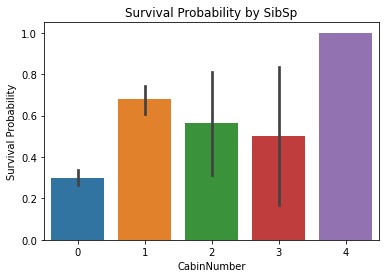

In [16]:
# Plotting  survival rates for each CabinNumber
sns.barplot(x='CabinNumber', y='Survived', data=data_train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by SibSp')

***
#### Conclusion
- Again, *CabinNumber* **is not significantly correlated** with the surviving probability, the distributions is quite flat. It seems thought that 0 Cabin has a significantly lower survival rate than *CabinNumber* > 0. I will follow up on that by having a look at the correlation between passengers that have or not a *Cabin*.
***

In [17]:
# Has Cabin
def get_has_cabin(cabin):
    ''' Returns 1 if passenger has a Cabin and 0 if not. '''
    return 1 if isinstance(cabin, str) else 0

In [18]:
# Applygin get_has_cabin to Cabin data
data_train['HasCabin'] = data_train['Cabin'].map(get_has_cabin)

Text(0.5, 1.0, 'Survival Probability by SibSp')

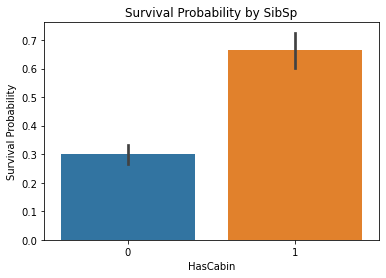

In [19]:
# Plotting  survival rates for each HasCabin
sns.barplot(x='HasCabin', y='Survived', data=data_train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by SibSp')

***
#### Conclusion
- *HasCabin* seems to **carry some information** about the survival probability. I will keep *HasCabin* as a final variable for the classification.
***

#### 1.2.2 Ticket

In [20]:
data_train['Ticket'].head(20)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
Name: Ticket, dtype: object

***
#### Notes
- Multiple patterns (single numbers, letter patterns + numbers ...)
- I will try to extract information by separating passengers with a ticket that is a number fromthe others (number + letter pattern). 
***

In [21]:
def get_is_number(ticket):
    ''' return flag for ticket that are numbers. '''
    try:
        float(ticket)
        return 1
    except:
        return 0

In [22]:
# Applying get_is_number to Ticket data
data_train['IsTicketNumber'] = data_train['Ticket'].map(get_is_number)

Text(0.5, 1.0, 'Survival Probability by IsTicketNumber')

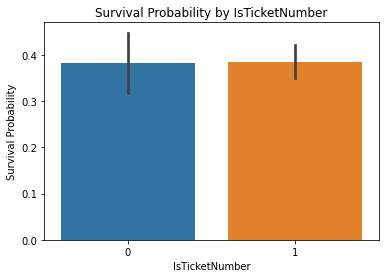

In [23]:
# Plotting survival rates for each IsNumber
sns.barplot(x='IsTicketNumber', y='Survived', data=data_train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by IsTicketNumber')

***
#### Conclusions
- *IsTicketNumber* has no information about survival rates. I will **drop completely** the *Ticket* variable.
***

### 1.2.3. Name

In [24]:
data_train['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

***
#### Notes
- *Name* is of course a specific variable for each passenger. The only possible information we can extract is the **title**.
- I found a list of may different titles, from which several appered only 1 or 2 times in the dataset. I then selected only the ones which appeared a number of times (Mr, Mrs, Ms, Miss, Dr, Rev) and grouped all the remanining ones into the code Other. 
***

In [25]:
# Extract title from Name data
title_dict = {
    'Mr.': 'Mr',
    'Mrs.': 'Mrs',
    'Ms.': 'Ms',
    'Master.': 'Ms',
    'Miss.': 'Miss',
    'Dr.': 'Dr',
    'Rev.': 'Rev'
}

def get_title_from_name(name):
    ''' Return NameTitle for each given Name. '''
    for word in name.split():
        if word[-1] != '.':
            continue
        return title_dict[word] if word in title_dict.keys() else 'Other'

    print('Warning: NameTitle was not extracted properly. ')
    return None

In [26]:
# Applying get_title_from_name to Name data
data_train['NameTitle'] = data_train['Name'].map(get_title_from_name)

In [27]:
data_train['NameTitle'].value_counts()

Mr       517
Miss     182
Mrs      125
Ms        41
Other     13
Dr         7
Rev        6
Name: NameTitle, dtype: int64

Text(0.5, 1.0, 'Survival Probability by NameTitle')

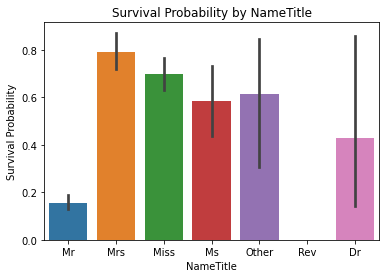

In [28]:
# Plotting survival rates for each NameTitle
sns.barplot(x='NameTitle', y='Survived', data=data_train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by NameTitle')

***
#### Conclusion
- There are differences in survival rates between *NameTitle*. In particular, Mr shows a much lower survival rate than the rest and Rev shows 0 survival probability. I will keep this variable for the classification.
***

#### 1.2.4. Sex

In [29]:
data_train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

Text(0.5, 1.0, 'Survival Probability by Sex')

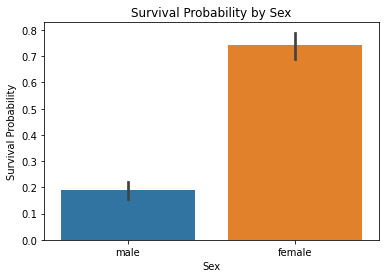

In [30]:
# Plotting survival rates for each Sex
sns.barplot(x='Sex', y='Survived', data=data_train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Sex')

***
#### Conclusion
- *Sex* is a very relevant variable and will be kept as it it.
***

#### 1.2.5. Embarked

In [31]:
data_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Text(0.5, 1.0, 'Survival Probability by Embarked')

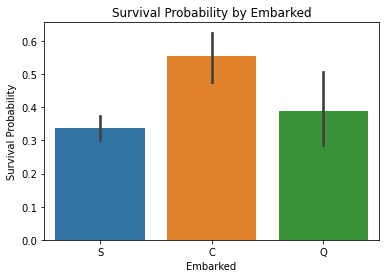

In [32]:
# Plotting survival rates for each Embarked
sns.barplot(x='Embarked', y='Survived', data=data_train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Embarked')

***
#### Conclusion
- *Embarked* is potentially relevant for the classification.
- Because there are only 3 values, I will keep it as it is and encode it in the next section.
***

<a id='data_processing'></a>
## 2. Processing the data (cleaning and feature engeneering)

***
All the conclusions from the previous section will be incorporated into one function called process_data. The missing values for the numerical variables will be filled with the means. This is not very relevant since the missing value rates are very small for the numerical variables, apart from *Age*. For *Age*, it still seems reasonable to replace the missing valuesfor its mean.
***

### 2.1 Processing data

***
#### Relevant steps
- *Pclass* is one-hot encoded into *IsFirstClass* and *IsSecondClass*.
- *Fare* is log normalized and replaced by *NormFare*.
- *Name* is turned into *NameTitle*, which is one-hot encoded into *IsTitleMr* etc.
- *Cabin* is replaced by *HasCabin*.
- *Sex* is one-hot encoded and replaced by *Is_male* only.
- *Embarked* is one-hot encoded. We are left with *EmbarkedS* and *EmbarkedQ*.
***

In [33]:
def process_data(data):
    '''
    Parameters
    ----------
    data: DataFrame
        Raw data (train or test)
        
    Returns
    -------
    DataFrame
        Processed data.
    '''
    df_out = pd.DataFrame()

    # Copying PassengerId
    df_out['PassengerId'] = data['PassengerId']
    
    # Copying Survived (if existing)
    if 'Survived' in data.columns:
        df_out['Survived'] = data['Survived']
    
    ## Numerical data
    # Pclass - one-hot encoding
    df_Pclass = pd.get_dummies(
        data['Pclass'],
        drop_first=False
    )
    df_out['IsFirstClass'] = df_Pclass[1]
    df_out['IsSecondClass'] = df_Pclass[2]

    # Age
    df_out['Age'] = data['Age']
    df_out['Age'].fillna(df_out['Age'].mean(), inplace=True)
    
    # SibSp
    df_out['SibSp'] = data['SibSp']
    df_out['SibSp'].fillna(df_out['SibSp'].mean(), inplace=True)

    # Parch
    df_out['Parch'] = data['Parch']
    df_out['Parch'].fillna(df_out['Parch'].mean(), inplace=True)
    
    # Fare
    df_out['NormFare'] = np.log(data['Fare'] + 1)
    df_out['NormFare'].fillna(df_out['NormFare'].mean(), inplace=True)
    
    ## Categorical data
    # Name
    df_NameTitle = data['Name'].map(get_title_from_name)
    df_NameTitleDummies = pd.get_dummies(
        df_NameTitle,
        prefix='IsTitle',
        prefix_sep='',
        drop_first=True
    )
    for var in df_NameTitleDummies.columns:
        df_out[var] = df_NameTitleDummies[var]
    
    # Cabin
    df_out['HasCabin'] = data['Cabin'].map(get_has_cabin)

    # Sex
    df_SexDummies = pd.get_dummies(
        data['Sex'],
        prefix='Is',
        prefix_sep='_',
        drop_first=True
    )
    for var in df_SexDummies.columns:
        df_out[var] = df_SexDummies[var]
    
    # Embarked
    df_EmbarkedDummies = pd.get_dummies(
        data['Embarked'],
        prefix='Embarked',
        prefix_sep='',
        drop_first=True
    )
    for var in df_EmbarkedDummies.columns:
        df_out[var] = df_EmbarkedDummies[var]
    
    return df_out

In [34]:
# Loading raw data (train and test)
raw_data_train = pd.read_csv('data/train.csv')
raw_data_test = pd.read_csv('data/test.csv')

In [35]:
# Process train and test raw data
processed_data_train = process_data(raw_data_train)
processed_data_test = process_data(raw_data_test)

In [36]:
processed_data_train.head()

,PassengerId,Survived,IsFirstClass,IsSecondClass,Age,SibSp,Parch,NormFare,IsTitleMiss,IsTitleMr,IsTitleMrs,IsTitleMs,IsTitleOther,IsTitleRev,HasCabin,Is_male,EmbarkedQ,EmbarkedS
0,1,0,0,0,22.0,1,0,2.110213,0,1,0,0,0,0,0,1,0,1
1,2,1,1,0,38.0,1,0,4.280593,0,0,1,0,0,0,1,0,0,0
2,3,1,0,0,26.0,0,0,2.188856,1,0,0,0,0,0,0,0,0,1
3,4,1,1,0,35.0,1,0,3.990834,0,0,1,0,0,0,1,0,0,1
4,5,0,0,0,35.0,0,0,2.202765,0,1,0,0,0,0,0,1,0,1


In [37]:
processed_data_test.head()

,PassengerId,IsFirstClass,IsSecondClass,Age,SibSp,Parch,NormFare,IsTitleMiss,IsTitleMr,IsTitleMrs,IsTitleMs,IsTitleOther,IsTitleRev,HasCabin,Is_male,EmbarkedQ,EmbarkedS
0,892,0,0,34.5,0,0,2.178064,0,1,0,0,0,0,0,1,1,0
1,893,0,0,47.0,1,0,2.079442,0,0,1,0,0,0,0,0,0,1
2,894,0,1,62.0,0,0,2.369075,0,1,0,0,0,0,0,1,1,0
3,895,0,0,27.0,0,0,2.268252,0,1,0,0,0,0,0,1,0,1
4,896,0,0,22.0,1,1,2.586824,0,0,1,0,0,0,0,0,0,1


### 2.2 Listing variables

In [38]:
# Listing variables

variables = list(processed_data_test.columns)
variables.remove('PassengerId')

print('Number of trainable variables = {}'.format(len(variables)))
for i, var in enumerate(variables):
    print('{}. {}'.format(i, var))

Number of trainable variables = 16
0. IsFirstClass
1. IsSecondClass
2. Age
3. SibSp
4. Parch
5. NormFare
6. IsTitleMiss
7. IsTitleMr
8. IsTitleMrs
9. IsTitleMs
10. IsTitleOther
11. IsTitleRev
12. HasCabin
13. Is_male
14. EmbarkedQ
15. EmbarkedS


### 2.3 Correlation Matrix

[Text(0.5, 0, 'PassengerId'),
 Text(1.5, 0, 'Survived'),
 Text(2.5, 0, 'IsFirstClass'),
 Text(3.5, 0, 'IsSecondClass'),
 Text(4.5, 0, 'Age'),
 Text(5.5, 0, 'SibSp'),
 Text(6.5, 0, 'Parch'),
 Text(7.5, 0, 'NormFare'),
 Text(8.5, 0, 'IsTitleMiss'),
 Text(9.5, 0, 'IsTitleMr'),
 Text(10.5, 0, 'IsTitleMrs'),
 Text(11.5, 0, 'IsTitleMs'),
 Text(12.5, 0, 'IsTitleOther'),
 Text(13.5, 0, 'IsTitleRev'),
 Text(14.5, 0, 'HasCabin'),
 Text(15.5, 0, 'Is_male'),
 Text(16.5, 0, 'EmbarkedQ'),
 Text(17.5, 0, 'EmbarkedS')]

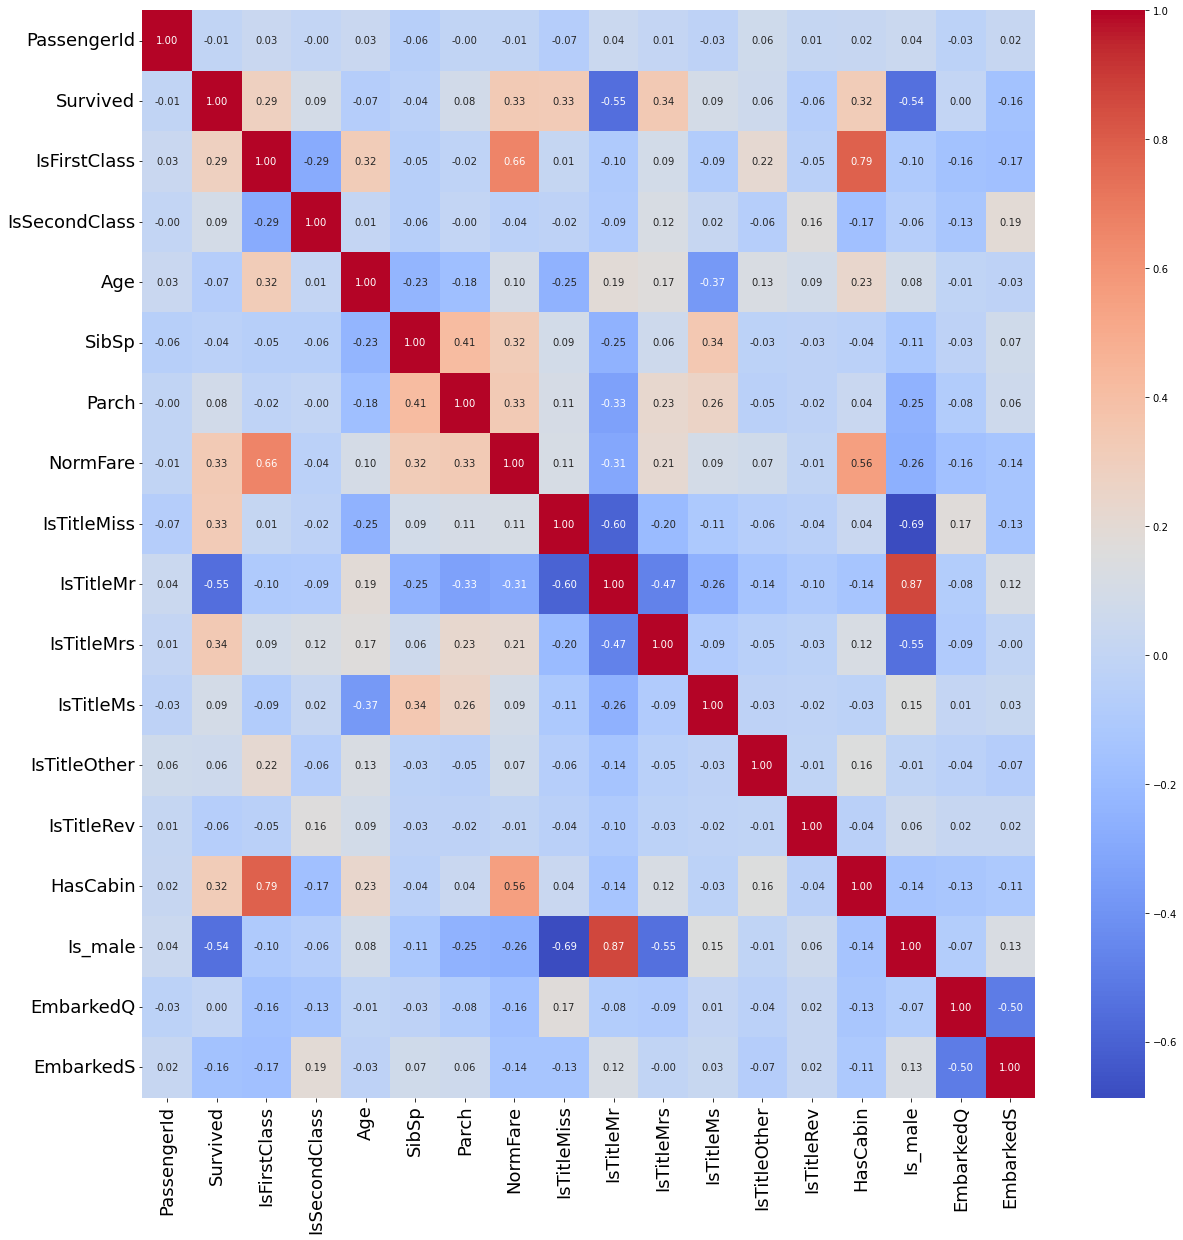

In [39]:
# Correlations
fig = plt.figure(figsize=(20, 20))
res = sns.heatmap(
    processed_data_train.corr(),
    annot = True,
    fmt = '.2f',
    cmap = 'coolwarm'
)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)

***
#### Notes
- Unsurprsingly, *Is_male* is strongly correlated with *IsTitleMr*.
***

<a id='model_building'></a>
## 3. Building and evaluating models 

### 3.1 Preparing data
***
#### Steps
- Selecting columns and creating X and y arrays
- Sppliting data into train and test
- Rescaling data using StandardScaler
***

In [40]:
X = processed_data_train.drop(columns=['PassengerId', 'Survived'])
y = processed_data_train['Survived']

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    GridSearchCV,
    validation_curve,
    learning_curve
)
from copy import copy

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=3
)

In [43]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

### 3.2 Buiilding models
***
The plan is to test a number of classification models and select one based on their performance.

#### List of classifiers
- Logistic Regression
- SVM
- Random Forest
- Gradient Boosting
- KNN

#### Steps
- For each classifier, a grid search will be first performed, scanning a non-extensive grid of parameters. For the sake of simplicity, I will not focus on performing the most complete grid search, but I will only choose a reasonable range of the most important parameters. The best estimator for it classifier and the best parameters will be store into the dict *results*. The grid search will be done with the function *perform_grid_search* defined below.
- A learning curve will be raised in order to validate the model. 
- The validation score will be evaluated by using the calculations done to raise the learning curve. Both the learning curve and the test score steps will be done with the function *get_test_cv_score_and_plot_learning_curve*. The validation scores and its error will be stored into the dict *results*.
***

In [44]:
def perform_grid_search(X_in, y_in, classifier, **parameters):
    '''
    Parameters
    ----------
    X_in: DataFrame
        X data
    y_in: DataFrame
        y data
    classifier: sklearn class
        Classsifier to be evaluated
    **parameters
        Parameters to be scanned by the grid search
        
    Returns
    -------
    (best estimator, best parameters)
    '''
    gs = GridSearchCV(
        classifier(),
        param_grid=parameters,
        n_jobs=-1,
        cv=5
    )
    gs.fit(X_in, y_in)
    print('BestParameters = {}'.format(gs.best_params_))
    print('BestScore = {:.4f}'.format(gs.best_score_)) 
    return copy(gs.best_estimator_), gs.best_params_

In [45]:
def get_test_cv_score_and_plot_learning_curve(X_in, y_in, classifier, ax=None):
    ''' Raise and plot learning curve and return the test score with its error.
    
    Parameters
    ----------
    X_in: DataFrame
        X data
    y_in: DataFrame
        y data
    classifier: sklearn class
        Classsifier to be evaluated
    ax: plt.Axis
        Optional

    Returns
    -------
    (mean test score, std test score)
    '''
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=classifier,
        X=X_in,
        y=y_in,
        train_sizes=np.linspace(0.1, 1, 10),
        cv=5
    )
    train_score_mean = np.mean(train_scores, axis=1)
    test_score_mean = np.mean(test_scores, axis=1)
    train_score_std = np.std(train_scores, axis=1)
    test_score_std = np.std(test_scores, axis=1)
    
    if ax is None:
        ax = plt.gca()

    COLORS = {'train': 'r', 'test': 'b'}
    
    ax.plot(train_sizes, train_score_mean, color=COLORS['train'], linestyle='none',
            marker='o', label='train')
    plt.fill_between(train_sizes, train_score_mean + train_score_std,
                     train_score_mean - train_score_std, alpha=0.15,
                     color=COLORS['train'])
    ax.plot(train_sizes, test_score_mean, color=COLORS['test'], linestyle='none',
            marker='s', label='test')
    plt.fill_between(train_sizes, test_score_mean + test_score_std,
                     test_score_mean - test_score_std, alpha=0.15,
                     color=COLORS['test'])
    ax.legend()
    ax.set_xlabel('train size')
    ax.set_ylabel('score')
    
    score_text = 'ValidationScore = {:.3f}+/-{:.3f}'.format(test_score_mean[-1],
                                                      test_score_std[-1])
    ax.set_title(score_text)
    return test_score_mean[-1], test_score_std[-1]

In [46]:
results = dict()

#### 3.2.1 Logistic Regression (LR)

In [47]:
from sklearn.linear_model import LogisticRegression

In [48]:
results['LR'] = dict()

In [49]:
results['LR']['estimator'], results['LR']['pars'] = perform_grid_search(
    X_train_std,
    y_train,
    LogisticRegression,
    C=[0.01, 0.1, 1.0, 10, 100],
    class_weight=['balanced', None],
    penalty=['l2']
)

BestParameters = {'C': 1.0, 'class_weight': None, 'penalty': 'l2'}
BestScore = 0.8301


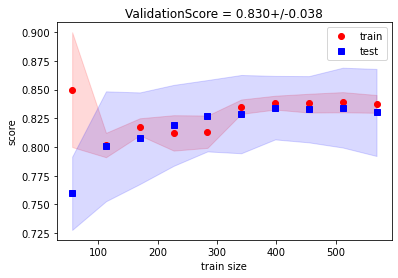

In [50]:
results['LR']['validation_score'] = get_test_cv_score_and_plot_learning_curve(
    X_train_std,
    y_train,
    results['LR']['estimator']
)

In [51]:
results['LR']['test_score'] = results['LR']['estimator'].score(X_test_std, y_test)

#### 3.2.2 SVM

In [52]:
from sklearn.svm import SVC

In [53]:
results['SVM'] = dict()

In [54]:
results['SVM']['estimator'], results['SVM']['pars'] = perform_grid_search(
    X_train_std,
    y_train,
    SVC,
    C=[0.01, 0.1, 1, 10, 100],
    #kernel=['linear', 'poly', 'rbf', 'sigmoid'],
    kernel=['rbf'],
    class_weight=['balanced', None]
)

BestParameters = {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
BestScore = 0.8287


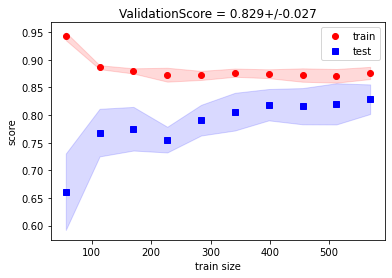

In [55]:
results['SVM']['validation_score'] = get_test_cv_score_and_plot_learning_curve(
    X_train_std,
    y_train,
    results['SVM']['estimator']
)

In [56]:
results['SVM']['test_score'] = results['SVM']['estimator'].score(X_test_std, y_test)

#### 3.2.3 Random Forest (RF)

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
results['RF'] = dict()

In [59]:
results['RF']['estimator'], results['RF']['pars'] = perform_grid_search(
    X_train_std,
    y_train,
    RandomForestClassifier,
    max_depth=[4, 5, 6]
)

BestParameters = {'max_depth': 6}
BestScore = 0.8287


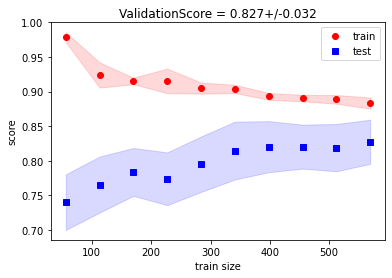

In [60]:
results['RF']['validation_score'] = get_test_cv_score_and_plot_learning_curve(
    X_train_std,
    y_train,
    results['RF']['estimator']
)

In [61]:
results['RF']['test_score'] = results['RF']['estimator'].score(X_test_std, y_test)

<AxesSubplot:xlabel='importance', ylabel='feature'>

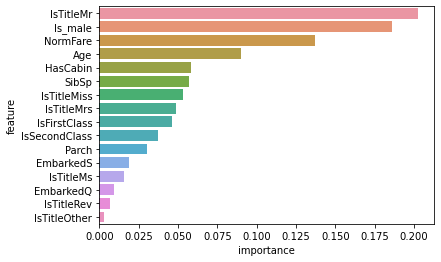

In [62]:
# Plotting feature importances
feat_imp = pd.DataFrame({
    'importance': results['RF']['estimator'].feature_importances_,
    'feature': X_train.columns}
)
order_reversed = feat_imp.sort_values('importance').feature[::-1]
sns.barplot(
    x='importance',
    y='feature',
    data=feat_imp,
    order=order_reversed
)

#### 3.2.4 Gradient Boosting (GB)

In [63]:
from sklearn.ensemble import GradientBoostingClassifier

In [64]:
results['GB'] = dict()

In [65]:
results['GB']['estimator'], results['GB']['pars'] = perform_grid_search(
    X_train_std,
    y_train,
    GradientBoostingClassifier,
    max_depth=[3, 4, 5, 6]
)

BestParameters = {'max_depth': 4}
BestScore = 0.8512


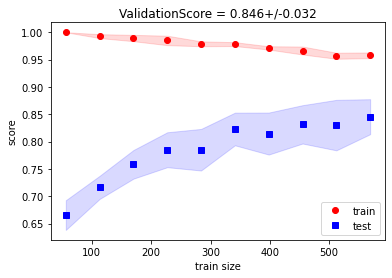

In [66]:
results['GB']['validation_score'] = get_test_cv_score_and_plot_learning_curve(
    X_train_std,
    y_train,
    results['GB']['estimator']
)

In [67]:
results['GB']['test_score'] = results['GB']['estimator'].score(X_test_std, y_test)

#### 3.2.5 KNN

In [68]:
from sklearn.neighbors import KNeighborsClassifier

In [69]:
results['KNN'] = dict()

In [70]:
results['KNN']['estimator'], results['KNN']['pars'] = perform_grid_search(
    X_train_std,
    y_train,
    KNeighborsClassifier,
    n_neighbors=[3, 4, 5, 6, 7, 8],
    weights=['uniform', 'distance']
)

BestParameters = {'n_neighbors': 3, 'weights': 'uniform'}
BestScore = 0.8260


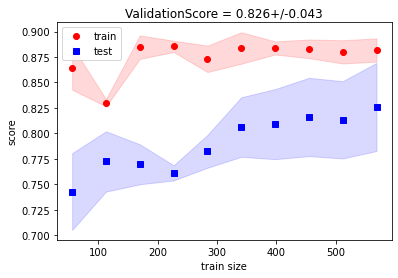

In [71]:
results['KNN']['validation_score'] = get_test_cv_score_and_plot_learning_curve(
    X_train_std,
    y_train,
    results['KNN']['estimator']
)

In [72]:
results['KNN']['test_score'] = results['KNN']['estimator'].score(X_test_std, y_test)

<a id='model_selection'></a>
## 4. Selecting the best model

***
I will first compare the validation and the test score of all models.
***

In [73]:
print('Model | Validation Score | Test Score') 
for key, value in results.items():
    print('{} | {:.3f}+/-{:.3f} | {:.3f}'.format(
        key, 
        value['validation_score'][0],
        value['validation_score'][1],
        value['test_score']
    ))

Model | Validation Score | Test Score
LR | 0.830+/-0.038 | 0.782
SVM | 0.829+/-0.027 | 0.771
RF | 0.827+/-0.032 | 0.799
GB | 0.846+/-0.032 | 0.810
KNN | 0.826+/-0.043 | 0.804


***
#### Conclusion
The validation scores look **very similar** for all models. Basically they all agree within uncertainties. There is no strong reason to pick any of these models since the perfomance is very similar and they are all relatively simple algorithms.
I choose the **Logistic Regression** to apply at the test data. It is a easy model to explain and very simple in terms of hyper-parameters to tune. The learning curve also seemed well behaved, no sign of overtraining. 
***

<a id='model_applying'></a>
## 5. Applying best model to test data

In [74]:
best_clf = results['LR']['estimator']

In [75]:
# Preparing data
X_test = processed_data_test.drop(columns='PassengerId')
X_test_std = scaler.transform(X_test)

In [76]:
# Calculating predictions
y_pred = best_clf.predict(X_test_std)

In [77]:
# Preparing output
data_submission = pd.DataFrame({'Survived': y_pred})
data_submission['PassengerId'] = processed_data_test['PassengerId']

In [78]:
data_submission.head()

,Survived,PassengerId
0,0,892
1,0,893
2,0,894
3,0,895
4,1,896


In [79]:
data_submission.to_csv('submission.csv', index=False)